In [1]:

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from collections import Counter
import nltk
import numpy as np
from sklearn.manifold import TSNE

In [2]:
#Importation et analyse textes:
nltk.download('punkt')
nltk.download('stopwords')

nlp = spacy.load("en_core_web_sm")
nlp.max_length = 7732498

fichiers = [r"C:\Users\hadrien\Tolkien\The-Children-of-Húrin-J.-R.-R.-Tolkien-Christopher-Tolkien-Z-Library.txt",
            r"C:\Users\hadrien\Tolkien\The-Fall-of-Gondolin-J.-R.-R.-Tolkien-Christopher-Tolkien-Z-Library.txt",
            r"C:\Users\hadrien\Tolkien\TheHobbit-J.R.R.Tolkien.txt",
            r"C:\Users\hadrien\Tolkien\The-Letters-of-J-R-R-Tolkien-Tolkien-John-Ronald-Reuel-Z-Library.txt",
            r"C:\Users\hadrien\Tolkien\The-Lord-of-the-Rings.txt",
            r"C:\Users\hadrien\Tolkien\The-Silmarillion-Tolkien-J.R.R.2004-Z-Library.txt",
            r"C:\Users\hadrien\Tolkien\Unfinished-Tales-of-Numenor-and-Middl...-Z-Library.txt"
]


all_sentences = []


for fichier in fichiers:
    with open(fichier, 'r', encoding='utf-8') as file:
        nombre_lignes_voulues = 24000
        texte = ""
        for i in range(nombre_lignes_voulues):
            ligne = file.readline()
            if not ligne:
                break
            texte += ligne
        sentences = nltk.sent_tokenize(texte)  
        all_sentences.extend(sentences)  

corpus = [simple_preprocess(sentence) for sentence in sentences]



# Création du modèle Word2Vec
model = Word2Vec(sentences=corpus, vector_size=100, window=7, min_count=1, sg=0)

model.build_vocab(corpus, progress_per=10000)


words = list(model.wv.index_to_key)
print('Vocabulary size: %d' % len(words))



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hadrien\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hadrien\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vocabulary size: 9860


In [3]:
#Entrainement du modèle:
model.train(corpus, total_examples=len(corpus), epochs=10)

(1515480, 2092560)

In [4]:
#Fonction pour ectraire les personnages:
def extract_characters(text):
    doc = nlp(text) 
    characters = []
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            characters.append(ent.text)
    
    return characters

In [5]:
#Sélectionner les 20 personnages les plus récurrents par texte:
top_characters_per_text = []


for fichier in fichiers:
    with open(fichier, 'r', encoding='utf-8') as file:
        text = file.read()
        characters = extract_characters(text)
        
        character_counts = {}
        for character in characters:
            if character in character_counts:
                character_counts[character] += 1
            else:
                character_counts[character] = 1
        
        sorted_characters = sorted(character_counts.items(), key=lambda x: x[1], reverse=True)
        
        
        top_characters = [char for char, count in sorted_characters[:20]]
        
        
        top_characters_per_text.append(top_characters)


for i, top_characters in enumerate(top_characters_per_text):
    print(f"Top 20 personnages du texte {i + 1}:")
    for j, character in enumerate(top_characters):
        print(f"{j + 1}. {character}")
    print()

Top 20 personnages du texte 1:
1. Túrin
2. Morwen
3. Morgoth
4. Mîm
5. Níniel
6. Brandir
7. Niënor
8. Mablung
9. Gwindor
10. Thingol
11. Beleg
12. Andróg
13. Amon Rûdh
14. Hithlum
15. Menegroth
16. Ered Wethrin
17. Dorlas
18. Orodreth
19. Haleth
20. Gurthang

Top 20 personnages du texte 2:
1. Morgoth
2. Eärendel
3. Meglin
4. Gondolin
5. Idril
6. Valinor
7. Voronwë
8. Melko
9. Hithlum
10. Glorfindel
11. Amon Gwareth
12. Ylmir
13. Silmaril
14. Galdor
15. Elemmakil
16. Maidros
17. Ulmo
18. Quendi
19. Rog
20. Ered Wethrin

Top 20 personnages du texte 3:
1. Bilbo
2. Baggins
3. Gollum
4. Beorn
5. Fili
6. Kili
7. Dale
8. Balin
9. William
10. Bert
11. Tom
12. Bilbo Baggins
13. Bard
14. Smaug
15. Bombur
16. Elrond
17. Girion
18. Bifur
19. Thror
20. Orcrist

Top 20 personnages du texte 4:
1. Tolkien
2. Christopher Tolkien
3. Rayner Unwin
4. J. R. R. Tolkien
5. Lewis
6. Unwin
7. Sam
8. Bilbo
9. Gollum
10. Michael Tolkien
11. Rayner
12. Stanley Unwin
13. Christopher
14. C. S. Lewis
15. Auden
16. G

In [6]:
#prétraitement de la liste:
import re

def preprocess_name(name):
    name = name.lower()
    name = name.strip()
    name = re.sub(r'[^\w\s]', '', name)
    return name


personnages_all = []
for name_list in top_characters_per_text:
    processed_names = [preprocess_name(name) for name in name_list]
    personnages_all.append(processed_names)
    
personnage_all1 = []

for sublist in personnages_all:
    personnage_all1.extend(sublist)
    
personnage_all = personnage_all1
 

In [7]:
# Ajoutez les noms de eprsonnages absent du modèle Word2vec:
mots_absents = []

for mot in personnage_all:
    if mot not in model.wv:
        mots_absents.append(mot)


model.build_vocab([mots_absents], update=True)


model.train([mots_absents], total_examples=len(mots_absents), epochs=model.epochs)

words = list(model.wv.index_to_key)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 9896


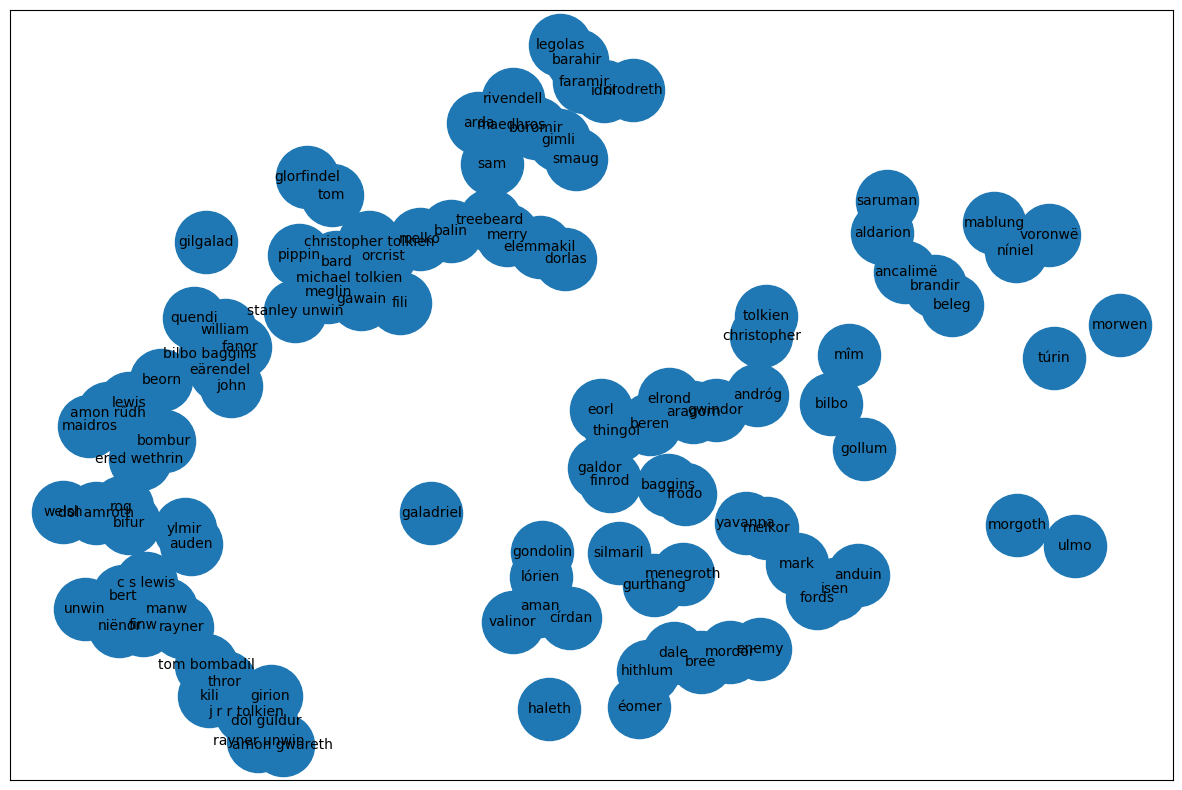

In [8]:
#Création du NetworkX:
vectors = {personnage: model.wv[personnage] for personnage in personnage_all}

vector_array = np.array([vectors[personnage] for personnage in personnage_all])

tsne = TSNE(n_components=2, random_state=0, perplexity=5)
vectors_2d = tsne.fit_transform(vector_array)


G = nx.Graph()


for i, personnage in enumerate(personnage_all):
    G.add_node(personnage, pos=vectors_2d[i])


for i, personnage1 in enumerate(personnage_all):
    for j, personnage2 in enumerate(personnage_all):
        if i < j:
            similarity = np.dot(vectors[personnage1], vectors[personnage2])
            G.add_edge(personnage1, personnage2, weight=similarity)


plt.figure(figsize=(15, 10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=2000)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.show()

In [9]:
#détection de communauté avec Louvain:
#suppresion des poids négatifs:
edges_to_remove = []
for u, v, data in G.edges(data=True):
    if 'weight' in data and data['weight'] < 0:
        edges_to_remove.append((u, v))

G.remove_edges_from(edges_to_remove)

from community.community_louvain import best_partition
best_part = best_partition(G)

In [10]:
#Essai pour trouver les tester les autres paramètres:
import community
resolutions = [0.1, 0.5, 1.0, 1.5, 2.0]

best_modularity = -1
best_partition = None
best_resolution = None


for resolution in resolutions:
    partition = community.best_partition(G, resolution=resolution)
    modularity = community.modularity(partition, G)
    
    if modularity > best_modularity:
        best_modularity = modularity
        best_partition = partition
        best_resolution = resolution


number_of_clusters = len(set(best_partition.values()))

print(f"Nombre de clusters optimal avec résolution {best_resolution}: {number_of_clusters}")

Nombre de clusters optimal avec résolution 1.0: 3


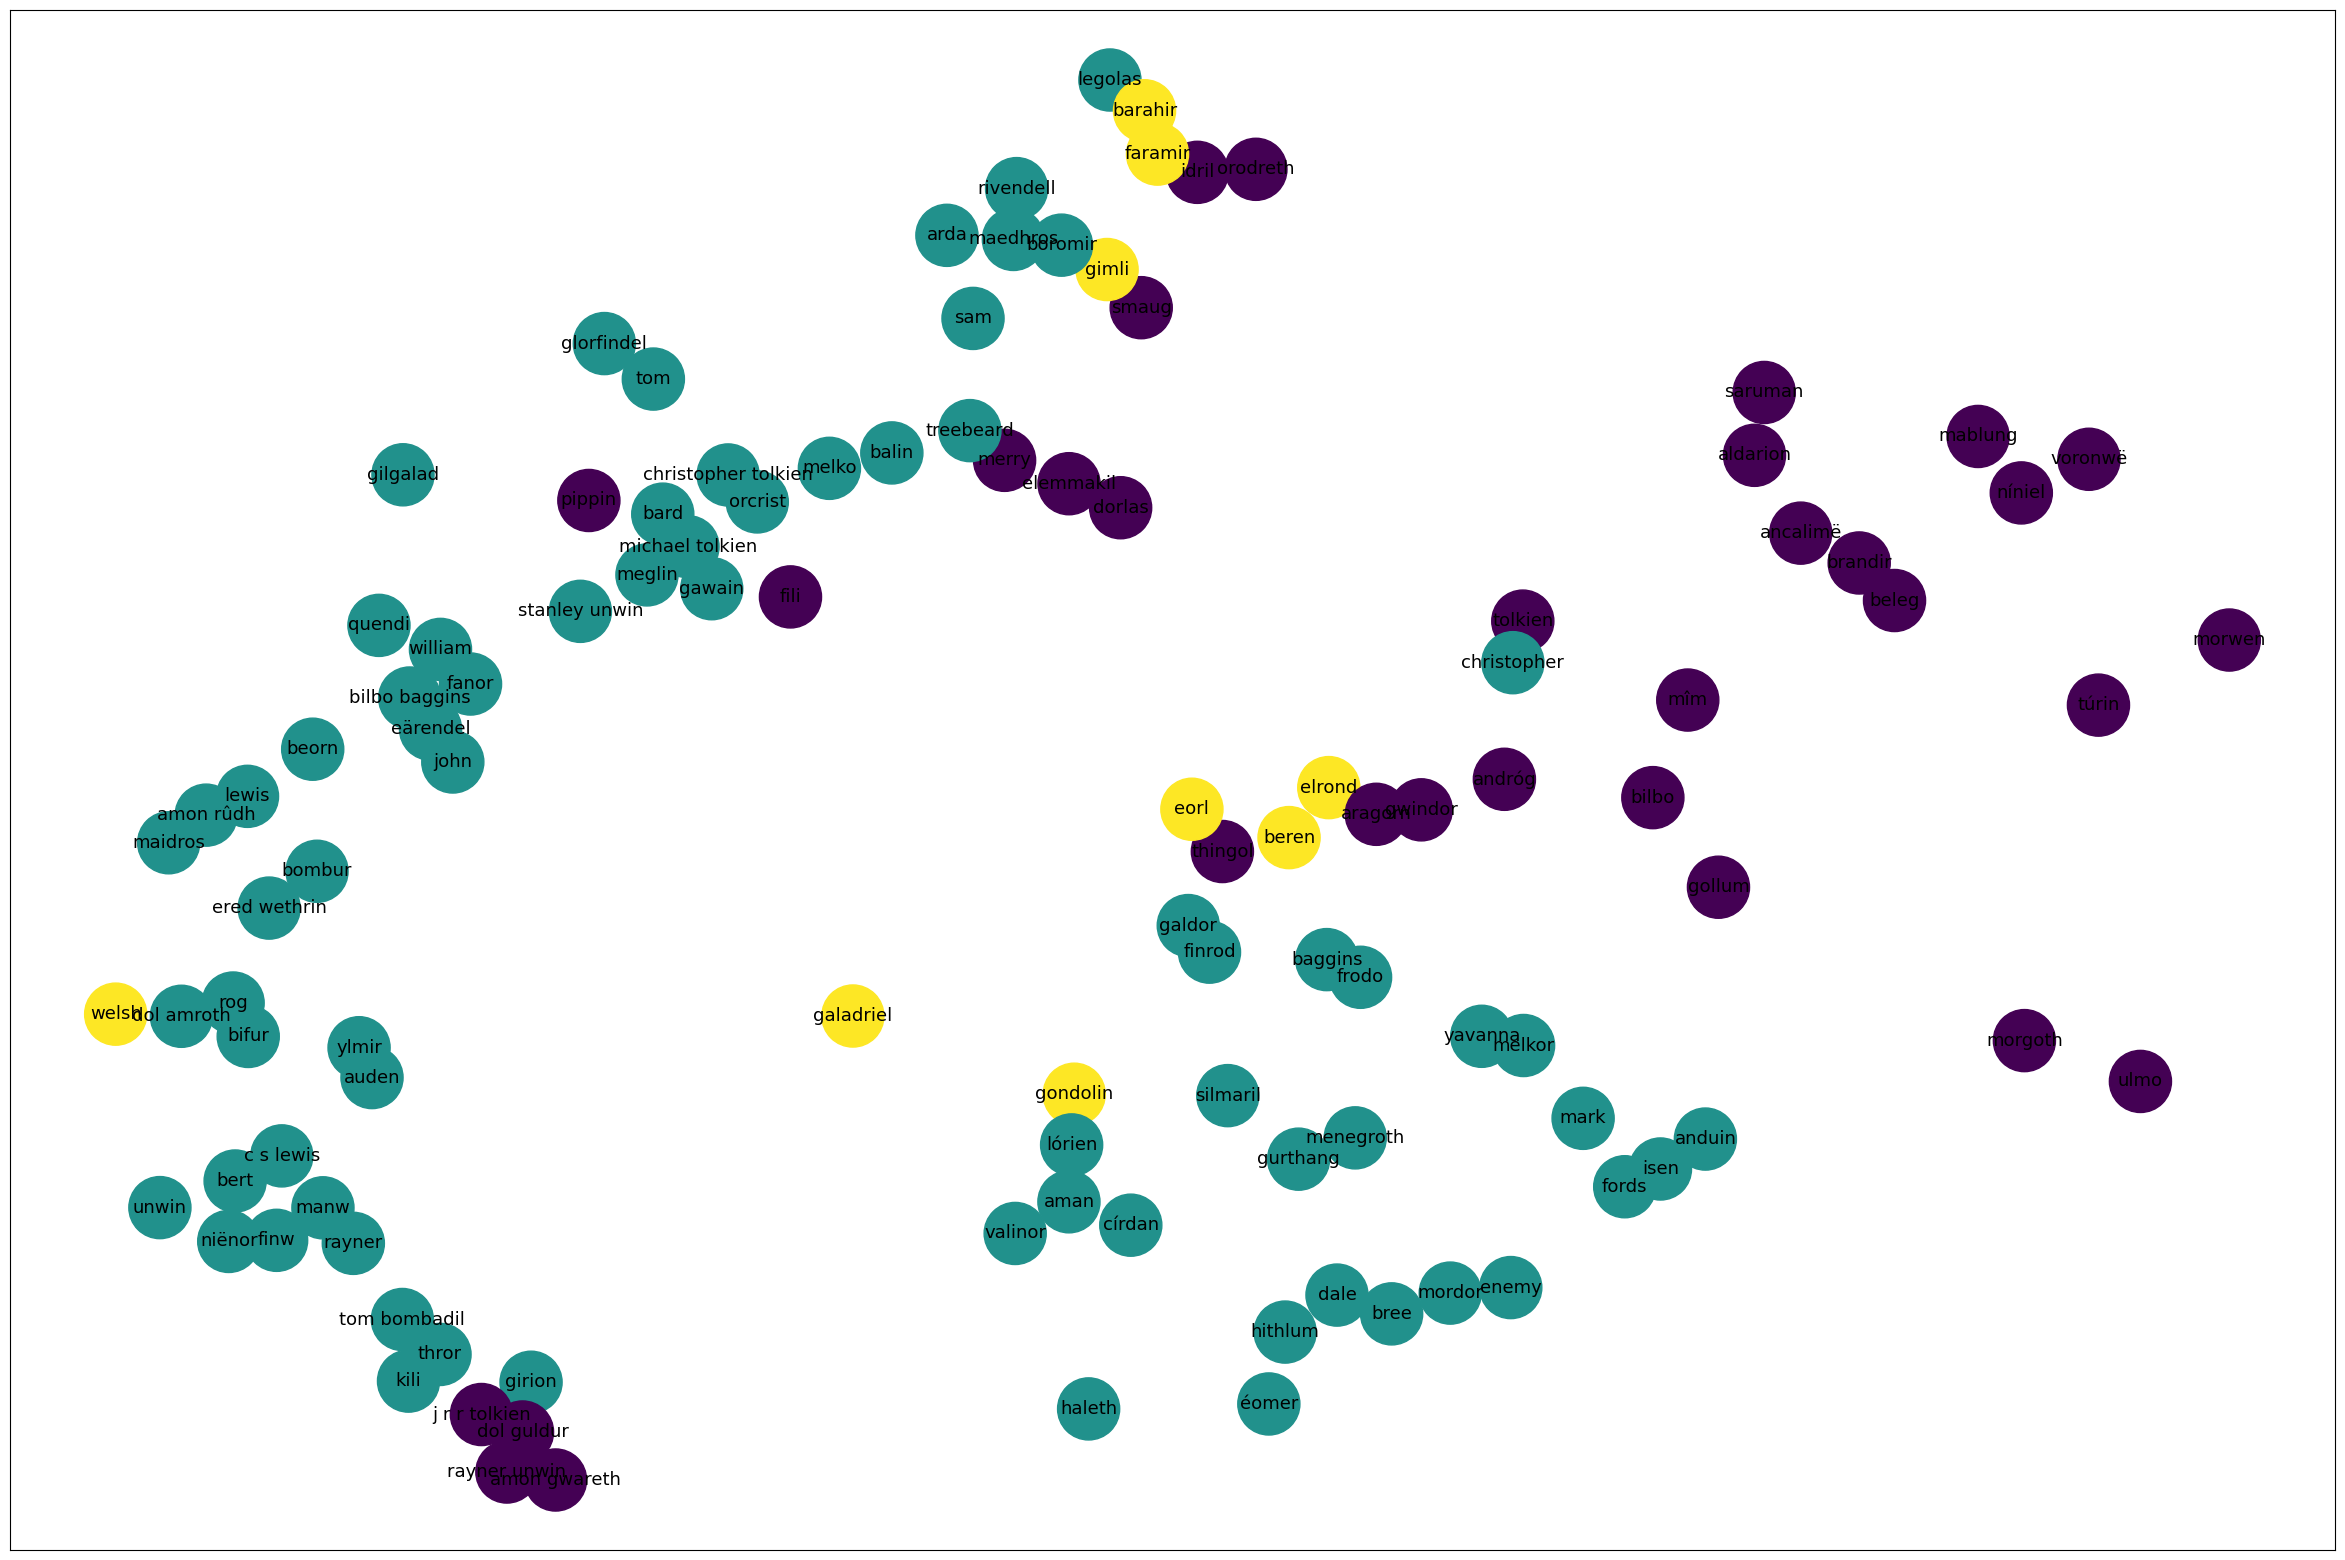

In [11]:
#graphe:
plt.figure(figsize=(30, 20)) 
pos = nx.get_node_attributes(G, 'pos')
node_cluster = list(best_part.values())
nx.draw_networkx_nodes(G, pos, node_color = node_cluster,node_size=2000)
nx.draw_networkx_labels(G, pos, font_size=13)
plt.show()

In [13]:
#Graphe en 3D:
from mpl_toolkits.mplot3d import Axes3D
pos_3d = nx.spring_layout(G, dim=3)

unique_communities = set(best_part.values())
community_colors = dict(zip(unique_communities, plt.cm.viridis(np.linspace(0, 1, len(unique_communities)))))

In [14]:
import plotly.graph_objects as go

node_names = [str(node) for node in G.nodes()]

trace = go.Scatter3d(
    x=[pos_3d[node][0] for node in G.nodes()],
    y=[pos_3d[node][1] for node in G.nodes()],
    z=[pos_3d[node][2] for node in G.nodes()],
    mode='markers',
    marker=dict(
        size=10,  
        color=[community_colors[best_part[node]] for node in G.nodes()],
        opacity=0.7,
    ),
    text=node_names,  
)

layout = go.Layout(
    title="Les Communautés de Tolkien",
    scene=dict(
        xaxis=dict(title='X Label', showgrid=False, showticklabels=False),
        yaxis=dict(title='Y Label', showgrid=False, showticklabels=False),
        zaxis=dict(title='Z Label', showgrid=False, showticklabels=False)
    )
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()